In [1]:
import tensorflow as tf
tf.random.set_seed(2)  

import numpy as np
import pandas as pd
import math
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,Conv1D,Conv2D, Flatten,MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, mean_squared_error,roc_curve, auc,classification_report
import autokeras as ak


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.style.use('default')
# plt.rc('text',usetex=False)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcParams["font.sans-serif"] = "Helvetica"
# import pydot
# register_matplotlib_converters()

In [2]:
import sys
print(sys.version)


3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


# Load data

In [3]:
start_date = datetime.date(2008,6,1)
end_date = datetime.date(2019,7,10)
# x_total = np.load("indicators/x_total.npy")
# y_total = np.load("indicators/y_total.npy")
# y_total_raw = np.load("indicators/y_total_raw.npy")

## import all x data
x_train_res = np.load("indicators/x_train_res.npy")
x_val_res = np.load("indicators/x_val_res.npy")
x_test = np.load("indicators/x_test.npy")
x_test_res = np.load("indicators/x_test_res.npy")
x_total_res = np.load("indicators/x_temp_res.npy")

x_train_res_close = x_train_res[:,:,:,[0]]
x_val_res_close = x_val_res[:,:,:,[0]]
x_test_close = x_test[:,:,:,[0]]
x_test_res_close = x_test_res[:,:,:,[0]]
x_total_res_close = x_total_res[:,:,:,[0]]

x_train_res_indicators5 = x_train_res[:,:,:,[3,14,29,15,5]]
x_val_res_indicators5 = x_val_res[:,:,:,[3,14,29,15,5]]
x_test_indicators5 = x_test[:,:,:,[3,14,29,15,5]]
x_test_res_indicators5 = x_test_res[:,:,:,[3,14,29,15,5]]
x_total_res_indicators5 = x_total_res[:,:,:,[3,14,29,15,5]]

# input all y data

y_train_res_raw = np.load("indicators/y_train_res_raw.npy")
y_val_res_raw = np.load("indicators/y_val_res_raw.npy")
y_test_raw = np.load("indicators/y_test_raw.npy")
y_test_res_raw = np.load("indicators/y_test_res_raw.npy")
y_total_res_raw = np.load("indicators/y_temp_res_raw.npy")

y_train_res = np.load("indicators/y_train_res.npy")
y_val_res = np.load("indicators/y_val_res.npy")
y_test = np.load("indicators/y_test.npy")
y_test_res = np.load("indicators/y_test_res.npy")
y_total_res = np.load("indicators/y_temp_res.npy")






In [4]:
# x_total_2d = x_total.reshape(x_total.shape[0],x_total.shape[1]*x_total.shape[2],x_total.shape[3],1)
# x_total_2d.shape
# x_total_3d = x_total.reshape(x_total.shape[0],x_total.shape[1],x_total.shape[2],x_total.shape[3],1)
# x_total_3d.shape
# #close MA120  RSI  MA60  EMA 

# x_train_temp = x_total[:,:,:,[3,14,29,15,5]]
# x_train_temp=x_train_temp.reshape(2759, 61, 360,5)

# x_train = x_train_temp[:2500,:,:,:]
# y_train = y_total[:2500,:]
# y_train_raw = y_total_raw[:2500,]

# x_test = x_train_temp[2500:,:,:,:]
# y_test = y_total[2500:,:]
# y_test_raw = y_total_raw[2500:,]

# y_train_raw

In [5]:
x_test.shape

(259, 61, 360, 35)

# 1. Plot methods

## 1.1 Loss & Accuracy Curves

In [6]:
def loss_accuracy(history):
# Loss Curves
    linewidth = 1.5
    plt.style.use('ggplot')
    plt.figure(figsize=[9,3.5])
    plt.plot(history.history['loss'],'r',linewidth=linewidth)
    plt.plot(history.history['val_loss'],'b',linewidth=linewidth)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=8)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()
    plt.savefig('figure/loss_curves_final_150.png',overwrite=True)
    # Accuracy Curves
    plt.figure(figsize=[9,3.5])
    plt.plot(history.history['binary_accuracy'],'r',linewidth=linewidth)
    plt.plot(history.history['val_binary_accuracy'],'b',linewidth=linewidth)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=8,loc='lower right')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()
    plt.savefig('figure/accuracy_curves_final_150.png',overwrite=True)

## 1.2 Show confusion matrix and ACC
https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [7]:
 def show_cm_auc(prediction,y_test):
    y_pred=np.argmax(prediction, axis=1)
    tn, fp, fn, tp = confusion_matrix(np.argmax(y_test, axis=1), y_pred).ravel()
    # actual_postive = tp + fn
    # actual_negative = fp + tn
    fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis=1), y_pred)
    auc = metrics.auc(fpr,tpr)
    f1_score = metrics.f1_score(np.argmax(y_test, axis=1), y_pred)
    conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    print('Confusion matrix:\n', conf_mat)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    plt.savefig('figure/confusion_final_150.png',overwrite=True)
    print('tn, fp, fn, tp, fpr[1], tpr[1], auc, f1_score',tn, fp, fn, tp, fpr[1], tpr[1], auc, f1_score)

# 2. CNN network

In [8]:
x_total_ak = x_total_res_indicators5.reshape(x_total_res_indicators5.shape[0],x_total_res_indicators5.shape[1]*x_total_res_indicators5.shape[2],x_total_res_indicators5.shape[3])
y_total_ak = y_total_res_raw

x_train_ak = x_train_res_indicators5.reshape(x_train_res_indicators5.shape[0],x_train_res_indicators5.shape[1]*x_train_res_indicators5.shape[2],x_train_res_indicators5.shape[3])
y_train_ak = y_train_res_raw

x_val_ak = x_val_res_indicators5.reshape(x_val_res_indicators5.shape[0],x_val_res_indicators5.shape[1]*x_val_res_indicators5.shape[2],x_val_res_indicators5.shape[3])
y_val_ak = y_val_res_raw


x_test_ak = x_test_indicators5.reshape(x_test_indicators5.shape[0],x_test_indicators5.shape[1]*x_test_indicators5.shape[2],x_test_indicators5.shape[3])
y_test_ak = y_test_raw

x_test_res_ak = x_test_res_indicators5.reshape(x_test_res_indicators5.shape[0],x_test_res_indicators5.shape[1]*x_test_res_indicators5.shape[2],x_test_res_indicators5.shape[3])
y_test_res_ak = y_test_res_raw


In [9]:
x_total_ak.shape

(2590, 21960, 5)

In [11]:
#  ImageClassifier
# Initialize the image classifier.
clf = ak.ImageClassifier(max_trials=10) # It tries 10 different models.
# Feed the image classifier with training data.
clf.fit(x_train_res_indicators5, y_train_res_raw,validation_data=(x_val_res_indicators5, y_val_res_raw),seed=None)


TypeError: __init__() got an unexpected keyword argument 'seed'

In [ ]:
# Predict with the best model.
predicted_y = clf.predict(x_test_indicators5)
# Evaluate the best model with testing data.
print(clf.evaluate(x_test_indicators5, y_test_raw))

In [13]:


# clf = ak.AutoModel(
#     inputs=ak.ImageInput(),
#     outputs=ak.ClassificationHead(num_classes = 2),
#     max_trials=10,
# #     seed=None
# )
# history_clf=clf.fit(x_train_res_indicators5, y_train_res_raw,validation_data=(x_val_res_indicators5, y_val_res_raw))
input_node = ak.ImageInput(shape = (x_total_res_indicators5.shape[1],x_total_res_indicators5.shape[2],x_total_res_indicators5.shape[3]))
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
#     block_type='resnet',
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=False)(input_node)

output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=10)
clf.fit(x_train_res_indicators5, y_train_res_raw,validation_data=(x_val_res_indicators5, y_val_res_raw))


TypeError: __init__() got an unexpected keyword argument 'seed'

In [28]:
# results = clf.predict(x_test_ak)

print(clf.evaluate(x_test_ak, y_test_raw))

AttributeError: 'NoneType' object has no attribute 'name_scope'

In [ ]:





clf =  ak.StructuredDataClassifier(max_trials=10)
clf.fit(x_train_ak, y_train_ak,validation_data=(x_val_ak, y_val_ak))
results = clf.predict(x_test_ak)

print(clf.evaluate(x_test, y_test_raw))

## 2.1 CNN1

In [ ]:
def CNN_model(x_train, activ_func="relu", dropout=0.20, loss="binary_crossentropy", optimizer="adam"):
    model = Sequential()
    input_shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3])

    model.add(Conv2D(filters=32, kernel_size=5, name='con1', activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    # 池化层1
    model.add(MaxPooling2D(pool_size=4))
    # dropout层1（减轻训练阶段过拟合）
    model.add(Dropout(dropout))
    # 卷积层2
    model.add(Conv2D(filters=64, kernel_size=4, name='con2', activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    # 池化层2
    model.add(MaxPooling2D(pool_size=4))
    # Flatten用于将多维输入一维化，常用在从卷积层到全连接层的过渡
    model.add(Flatten())
    # dropout层2（减轻训练阶段过拟合）
    model.add(Dropout(dropout))
    # 全连接层
    model.add(Dense(units=2, activation='sigmoid'))
    # 设置优化器，损失函数，性能评估
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    plot_model(model, to_file='model/model_plot_CNN1.png', show_shapes=True, show_layer_names=True)
    return model

In [ ]:
def CNN_RUN1(x_train,y_train,nb_epoch,dropout,batch_size):
    model = CNN_model(x_train, activ_func="sigmoid", dropout=dropout, loss=binary_crossentropy)
    history = model.fit(x_train , y_train, epochs=nb_epoch, batch_size=batch_size,shuffle = True, validation_split=0.1)
    # verbose = 0,, callbacks = [early_stopping,TQDMCallback()]
    # history = model.fit(x_train , y_train, epochs=nb_epoch, batch_size=128,shuffle = True, validation_split=0.1,verbose=2) 
    return model, history
    #size 16 50epoch

### 2.1.1 Evaluate CNN1 test data

In [ ]:
# import pydot
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [11]:
# cnn_model_1 ,history_1= CNN_RUN1(x_train_res, y_train_res, nb_epoch = 60, dropout = 0.3, batch_size = 16)
cnn_model_1 ,history_1= CNN_RUN1(x_total_res_indicators5, y_total_res, nb_epoch = 30, dropout = 0.4, batch_size = 128)

Train on 2331 samples, validate on 259 samples
Epoch 1/30
2331/2331 [==============================] - 2s 962us/sample - loss: 0.7477 - binary_accuracy: 0.5199 - val_loss: 0.7412 - val_binary_accuracy: 0.3533
Epoch 2/30
2331/2331 [==============================] - 1s 273us/sample - loss: 0.7327 - binary_accuracy: 0.5272 - val_loss: 0.7355 - val_binary_accuracy: 0.3456
Epoch 3/30
2331/2331 [==============================] - 1s 275us/sample - loss: 0.7256 - binary_accuracy: 0.5234 - val_loss: 0.7234 - val_binary_accuracy: 0.5135
Epoch 4/30
2331/2331 [==============================] - 1s 273us/sample - loss: 0.7207 - binary_accuracy: 0.5245 - val_loss: 0.7300 - val_binary_accuracy: 0.3417
Epoch 5/30
2331/2331 [==============================] - 1s 274us/sample - loss: 0.7160 - binary_accuracy: 0.5236 - val_loss: 0.7180 - val_binary_accuracy: 0.4440
Epoch 6/30
2331/2331 [==============================] - 1s 275us/sample - loss: 0.7129 - binary_accuracy: 0.5191 - val_loss: 0.7227 - val_binar

In [12]:
# model save
# cnn_model_1.save_weights('model/cnn_model_1_a.h5', overwrite=True)
cnn_model_1.save('model/model_cnn1_epochs30_dropout0.3_batch_size8.h5')  # creates a HDF5 file 'my_model.h5
np.save("model/history_cnn1_epochs30_dropout0.3_batch_size8.npy",history_1.history)
# del model  # deletes the existing model
# cnn_model_1 = load_model('model/cnn1_80.h5')

In [13]:
def model_preedict(model, x_test, y_test, x_test_res, y_test_res):
    prediction = model.predict(x_test)
    score = model.evaluate(x_test, y_test)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # resampled test data
    prediction_res = cnn_model_1.predict(x_test_res)
    score_res = cnn_model_1.evaluate(x_test_res, y_test_res)
    print('Test loss:', score_res[0])
    print('Test accuracy:', score_res[1])
    return prediction, prediction_res

In [14]:
# prediction_1, prediction_1_res = model_preedict(cnn_model_1, x_test, y_test, x_test_res, y_test_res)
# prediction_1, prediction_1_res = model_preedict(cnn_model_1, x_test_close, y_test, x_test_res_close, y_test_res)
prediction_1, prediction_1_res = model_preedict(cnn_model_1, x_test_indicators5, y_test, x_test_res_indicators5, y_test_res)

259/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


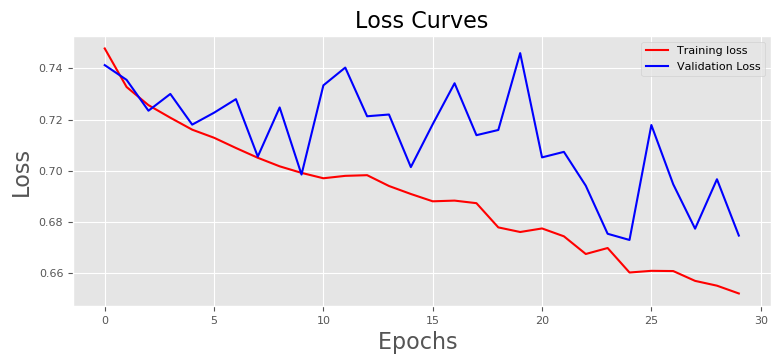

<Figure size 640x480 with 0 Axes>

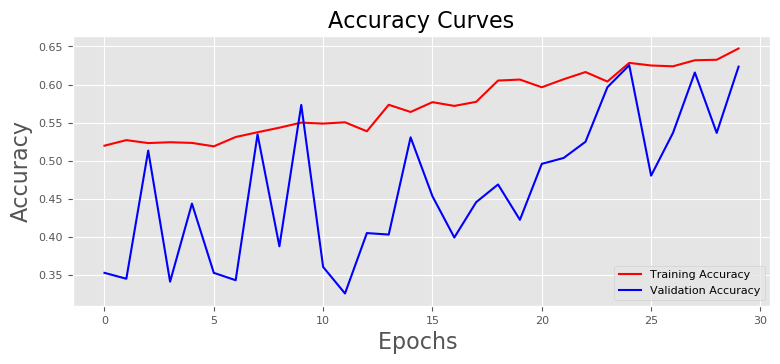

Confusion matrix:
 [[69 63]
 [81 46]]


<Figure size 640x480 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


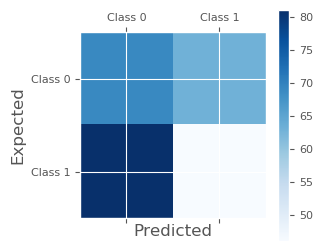

tn, fp, fn, tp, fpr[1], tpr[1], auc, f1_score 69 63 81 46 0.4772727272727273 0.36220472440944884 0.4424659985683608 0.3898305084745763
Confusion matrix:
 [[69 63]
 [86 46]]


<Figure size 640x480 with 0 Axes>

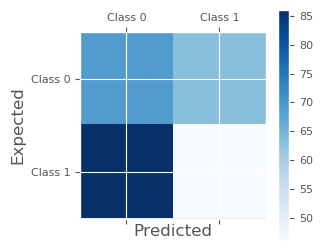

tn, fp, fn, tp, fpr[1], tpr[1], auc, f1_score 69 63 86 46 0.4772727272727273 0.3484848484848485 0.43560606060606066 0.38174273858921165


<Figure size 640x480 with 0 Axes>

In [15]:
loss_accuracy(history_1)
show_cm_auc(prediction_1,y_test)
show_cm_auc(prediction_1_res,y_test_res)

## 2.2 CNN2

In [ ]:
def CNN_model2(x_train, activ_func="relu", dropout=0.20, loss="binary_crossentropy", optimizer="adam"):
    model = Sequential()
    input_shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3])

    # model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',name='con1', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3,3), name='con2', activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout))

    # model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same',name='con3', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), name='con4', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout))

    # model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same',name='con5', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), name='con6', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout))

    # Flatten用于将多维输入一维化，常用在从卷积层到全连接层的过渡
    model.add(Flatten())
    model.add(Dense(units=256,activation='relu'))
    # model.add(Dense(units=256))
    model.add(Dropout(dropout))

    model.add(Dense(units=2, activation='sigmoid'))
    # 设置优化器，损失函数，性能评估
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    plot_model(model, to_file='model/model_plot_CNN2.png', show_shapes=True, show_layer_names=True)
    return model

In [ ]:
# model = CNN_model2(x_train_res, activ_func="sigmoid", dropout=0.3, loss=binary_crossentropy)
# plt.plot(plot_model(model))
# model.summary()

In [ ]:
def CNN_RUN2(x_train,y_train,nb_epoch,dropout,batch_size):
    model = CNN_model2(x_train, activ_func="sigmoid", dropout=dropout, loss = binary_crossentropy)
    history = model.fit(x_train , y_train, epochs=nb_epoch, batch_size=batch_size, shuffle = True, validation_split=0.1,verbose = 0,callbacks = [TQDMCallback(),early_stopping])
#     history = model.fit(x_train , y_train, epochs=nb_epoch, batch_size=batch_size, shuffle = False, validation_split=0.2)
    return model, history

### 2.2.1 Evaluate CNN2 test data

In [ ]:
cnn_model_2 ,history_2= CNN_RUN2(x_train, y_train, nb_epoch = 50, dropout = 0.4, batch_size = 16)
# cnn_model2.save_weights('model/cnn_model_1_b.h5', overwrite=True

In [ ]:
prediction_2 = cnn_model_2.predict(x_test)
score_2 = cnn_model_2.evaluate(x_test, y_test)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

In [ ]:
loss_accuracy(history_2)
# show_cm_auc(prediction_2,y_test)

In [ ]:
# cnn_model.save_weights('model/cnn_model_1_a.h5', overwrite=True)
cnn_model_2.save('model/cnn2_30.h5')  # creates a HDF5 file 'my_model.h5
np.save("model/history_2_cnn2_30.npy",history_2.history)
# del model  # deletes the existing model
# model = load_model('my_model.h5')

## 2.3 Compare with random predict

In [ ]:
def compare_random(y_data):
    data_size = y_data.shape[0]
    random_data = np.random.randint(0,2,size=data_size)
    print(random_data)
    positive_count = np.sum(y_data == 1)
    negative_count = np.sum(y_data == 0)
    print(data_size,positive_count,negative_count)
    predicted_positive_count = np.sum(random_data == 1)
    predicted_negative_count = np.sum(random_data == 0)
    print(random_data.shape[0],predicted_positive_count,predicted_negative_count)
    true_positive_count = 0
    false_positive_count = 0
    false_negative_count = 0
    true_negative_count = 0
    for i in range(data_size):
        if y_data[i] == 1 and random_data[i] == 1:
            true_positive_count = true_positive_count + 1
        elif y_data[i] == 0 and random_data[i] == 1:
            false_positive_count = false_positive_count + 1
        elif y_data[i] == 1 and random_data[i] == 0:
            false_negative_count = false_negative_count + 1 
        elif y_data[i] == 0 and random_data[i] == 0:
            true_negative_count = true_negative_count  + 1
    tpr = true_positive_count/positive_count
    fpr = false_positive_count/negative_count
    accurancy = (true_positive_count + true_negative_count)/( true_positive_count + false_positive_count + false_negative_count + true_negative_count)
    fpr1,tpr1,threshold = roc_curve(y_data, random_data) 
    accurancy1 = auc(fpr1,tpr1)
    plot_curve(tpr1,fpr1,0,accurancy1)
    return true_positive_count,false_positive_count,false_negative_count,true_negative_count, accurancy,accurancy1,tpr,fpr, tpr1,fpr1

In [ ]:
def plot_curve(tpr,fpr,f1,accurancy):
    plt.figure(figsize=(5,5))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % accurancy) ###假正率为横坐标，真正率为纵坐标做曲线
    # plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
compare_random(y_test_raw)

## Autokeras